In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.dataSteward import DataSteward
from utils.dataManagers.informations import informer
from utils.predictions import *
from utils.dataManagers.dataWrangler import *
from utils.ClassifierResults import *

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso

In [2]:
ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response
ytrain_logged = np.log1p(ytrain)

Data Steward is class containing test and train data. In initialization we can set type of operations on data.
For categorical data I provided options:
* mapper_only:

This option maps categorical data according to value mapping contained in mapper class. For example:
column 'Street' got:
Street_MAPPING = {
    'Grvl': 'Gravel',
    'Pave': 'Paved'
}
Mapper class contains also column descriptions and null values mappings for categorical features. All those informations were extracted from Kaggle competition description. Informer class serves this data as pandas series.
But mapper doesn't have all mappings thus I created:
* mapper_and_most_frequent:

Option fills null values in columns that left with most frequent value across dataset.

For number type data I use Imputer so aviable options are:
 * mean,
 * median,
 * most_frequent
 
 You can obtain not changed values by leaving empty constructor.

All those options are performed on train an test datasets separatly, but filling with values of whole dataset may be a better idea and best I can think of for now is putting values 'content wisely'- look at missing values and decide separately for each of it.

In [3]:
number_type = get_number_types(train)

skew_thresshold = 2
skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= skew_thresshold].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)


Here I exctract dummy variables, and log skewed feature columns by given thresshold.

In [4]:
from sklearn.metrics import mean_squared_log_error
def scoring_function(actual, predicted):
    return np.sqrt(mean_squared_log_error(actual, predicted))

def fit_ensemble(models, ensemble_name, X_train, y_train, X_test, k_folds=5, cv_folds=5):
    ensemble = Ensembler(models, ensemble_name)
    ensemble.fit(X_train, y_train, n_jobs=11, calculate_validation_error_method=scoring_function, k_folds=k_folds, cv_folds=cv_folds)
    results = ensemble.calculate_results_objects(X_train, y_train, X_test, predictions_form_restoring_method=restoring_method, plot_best_results=False, store_predictions_score=True)
    return ensemble, results

Fit_ensemble is a wrapper on my Ensembler class.

Ensembler class contains models, models are in form of class RegressionModel, both can be found in predictions file. **In modeling part below You can find way to initialize it and run it. **

Here is more information on how I am doing it.

We want to build different models and compare different algorithms, but if we want to compare them in a propper way we have to evaluate them on the same part of the data, thus we have to use nested cross validation in nested cross validation. This scenario is described by picture below, which comes from Sebastian Raschka [blog post](https://sebastianraschka.com/faq/docs/evaluate-a-model.html).
<img src='https://sebastianraschka.com/images/faq/evaluate-a-model/nested-k-fold.png'></img>

In Ensembler fit method:
* I am **creating k k_fold splits **
(after fitting they can be found in kfold_split_indexes, later Ensembler could have a method add model which would fit new model on those folds).
* **fitting every model given in Ensembler initialization,**
    * we can perform gridSearch or randomSearch(by setting n_iter parameter in RegressionModel creation, to see more about RegressionModel look at it's documentation). This searching algorithms perform cross validation inside and automaticly chooses best performing ones.
    * think about setting different n_jobs parameter (number of jobs to run in parallel), mine is 11.
* calculate mean_squared_error.
    *  because I use double logged output implementation is using np.expm1, but normally It wouldn't look like that. Probably putting method of evaluation in RegressionModel would be a better idea.
* basing on error calculated above I choose best performing hyperparameters and I ** retrain model on whole training dataset.**

We can use ** predict ** method to get predictions directly, or use ** calculate_results_objects ** to gain deeper insight. Method will return ClassifierResults objects that have helpfull methods, one that you should look at is plot_results. Visualization is in my opinion most valuable source of information. This method have most common plots, that we want to see after plotting model. You can also store classifier, get most important and excluded columns. Values of this objects have information about most model parameters, cv results, grid object used in previous step and so on.

In [5]:
def get_best_quantile_columns(feature_importances_column, quantile):
    return list(feature_importances_column[feature_importances_column > feature_importances_column.quantile(quantile)].index)

def get_train_subsets(best_cols, outliers_idx, xtrain, ytrain, xtest):
    return xtrain[~xtrain.index.isin(outliers_idx)].loc[:, best_cols], ytrain[~ytrain.index.isin(outliers_idx)], xtest.loc[:, best_cols]

def restoring_method(val):
    return np.expm1(np.expm1(val))

def get_weights(X):
    cat_cols = X.select_dtypes(['uint8'])
    weights = pd.Series(np.ones(X.shape[0]), index=X.index)
    for col in cat_cols:
        argmin = X[col].value_counts().argmin()
        weights[X.loc[X[col] == argmin].index] += 10
    return pd.Series(weights)

Below we set variables we need to perform calculations.

Outliers_idx are indexes of samples I classified as outliers, feature_importances.csv contains importance of columns based on previous calculations. I've obtain those results by performing fit operations on lasso and xgb models using resampled train data. Outlier was recognized as sample that was out of residual plot 90% for lasso and 95% for xgb. For features importances it is a simple mean of feature_importances_. I've also used boruta method to get another ranking column. After putting this information in dataframe I perform MinMax scalling, add values together and select best 50%.

This method should be performed once again if some features are added or null values are filled in another way

I've also created get_weights method- it is used in tree algorithms. Here I simply add more weight to undersampled rows.

In [6]:
outliers_idx = [  31,  186,  411,  463,  496,  524,  582,  589,  633,  667,  689, 711,  969,  971, 1063, 1299, 1325, 1384, 1433, 1454]

feature_importances = pd.read_csv('coefficients/feature_importances.csv', index_col='ColumnName')

cols_to_drop = [
    '_MSZoning_C (all)',
    '_MSSubClass_160',
]

best_cols_quantile = .5
best_cols = get_best_quantile_columns(feature_importances.coef_sum, best_cols_quantile)
best_cols = [v for v in best_cols if v not in cols_to_drop]
X_train, y_train, X_test = get_train_subsets(best_cols, outliers_idx, trainWithDummies, np.log1p(ytrain_logged), testWithDummies)

weights = get_weights(X_train)

In [73]:
len(best_cols)

117

It is worth trying pca as another way to perform feature selection.

# Modeling part

For modeling I am using 117 features and output it double logged (double logging gave me better results). Data is standarized.

I have added result obejcts of this ensemble. You can find them in ensembles folder. Below calulations part there is a method loading them to memory. Next there is example of my final submission.

Here we can see progress and output information about our learning part. Outliers, results and scores can be automaticly stored if speciffied. I have added example of those files.
Ensemble_predictions is method to reweight output of selected algorithms, store flag decides weather to store csv file on disc.

In [12]:
models = []

lasso_param_grid = dict(alpha=[1e-6])
lasso_model = RegressionModel(RegressionResults, Lasso(normalize=False, max_iter=7000), lasso_param_grid, name='lasso')
models.append(lasso_model)

xgb_param_grid = {  
    "n_estimators": [700],
    "max_depth": [3],
    "learning_rate":[.07],
    "colsample_bytree": [.4],
    "subsample": [.5],
    "min_child_weight": [1.5]
}
xgb_model = RegressionModel(TreeResults, xgb.XGBRegressor(), xgb_param_grid, name='xgb_with_weights', weights=weights)
models.append(xgb_model)


xgb_param_grid = {  
    "n_estimators": [700],
    "max_depth": [3],
    "learning_rate":[.07],
    "colsample_bytree": [.4],
    "subsample": [.5],
    "min_child_weight": [1.5]
}
xgb_model = RegressionModel(TreeResults, xgb.XGBRegressor(), xgb_param_grid, name='xgb_without_weights')
models.append(xgb_model)

ensemble_name = f'ensemble_of_lasso_xgb_models_skew_thresshold({skew_thresshold})_best_cols_quantile({best_cols_quantile})'
lasso_xgb_ensemble, lasso_xgb_results = fit_ensemble(models, ensemble_name, X_train, y_train, X_test)

kfold number: 0 for model: lasso, time is: 2017-11-09 11:47:25.897741
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0020694995124062167
kfold number: 0 for model: xgb_with_weights, time is: 2017-11-09 11:47:33.605098
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.002176177977039683
kfold number: 0 for model: xgb_without_weights, time is: 2017-11-09 11:47:43.264727
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0021185318790938623
kfold lap started at: 2017-11-09 11:47:25.896237 and ended at: 2017-11-09 11:47:54.061152, took: 0:00:28.164915
---
kfold number: 1 for model: lasso, time is: 2017-11-09 11:47:54.062657
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0021344276714046775
kfold number: 1 for model: xgb_with_weights, time is: 2017-11-09 11:48:02.219800
Performing GridSear

In [13]:
from sklearn.linear_model import Ridge, ElasticNet

models = []

lasso_param_grid = dict(alpha=[1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4])
lasso_model = RegressionModel(RegressionResults, Lasso(normalize=False, max_iter=7000), lasso_param_grid, name='lasso')
models.append(lasso_model)

ridge_param_grid = dict(alpha=[1e-4, 1e-3, 1e-2, .1, 1, 3])
ridge_model = RegressionModel(RegressionResults, Ridge(normalize=False, max_iter=7000), ridge_param_grid, name='ridge')
models.append(ridge_model)

elasticNet_param_grid = dict(alpha=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], l1_ratio=[.01, .1, .5, .9, .99])
elasticNet_model = RegressionModel(RegressionResults, ElasticNet(normalize=False, max_iter=5000), elasticNet_param_grid, name='ElasticNet')
models.append(elasticNet_model)

rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [15, 20, 30, 50], 'max_features': ['sqrt']}
rf_model = RegressionModel(TreeResults, RandomForestRegressor(), rf_param_grid, name='random_forest')
models.append(rf_model)

xgb_param_grid = {  
    "n_estimators": [500, 700],
    "max_depth": [3],
    "learning_rate":[.07, .075],
    "colsample_bytree": [.4, .5],
    "subsample": [.5],
    "min_child_weight": [1.5]
}
xgb_model = RegressionModel(TreeResults,  xgb.XGBRegressor(), xgb_param_grid, name='xgb')
models.append(xgb_model)

ensemble_name = f'ensemble'
ensemble, results = fit_ensemble(models, ensemble_name, X_train, y_train, X_test)

kfold number: 0 for model: lasso, time is: 2017-11-09 11:51:26.071140
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0020671171805023724
kfold number: 0 for model: ridge, time is: 2017-11-09 11:51:41.841750
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0020670104383738635
kfold number: 0 for model: ElasticNet, time is: 2017-11-09 11:51:56.756025
Performing GridSearchCV.


c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Current mean_squared_error on validation set(logged pred and output) is: 0.0020671181000128844
kfold number: 0 for model: random_forest, time is: 2017-11-09 11:52:16.466975
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0024926988162256598
kfold number: 0 for model: xgb, time is: 2017-11-09 11:52:35.892349
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0021185318790938623
kfold lap started at: 2017-11-09 11:51:26.069135 and ended at: 2017-11-09 11:52:56.373787, took: 0:01:30.304652
---
kfold number: 1 for model: lasso, time is: 2017-11-09 11:52:56.375792
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0022257803518105084
kfold number: 1 for model: ridge, time is: 2017-11-09 11:53:10.964917
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.002233259282916422
kfold number: 1 for mode

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Current mean_squared_error on validation set(logged pred and output) is: 0.002174098944174006
kfold number: 2 for model: ridge, time is: 2017-11-09 11:54:40.174061
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0020974481159898237
kfold number: 2 for model: ElasticNet, time is: 2017-11-09 11:54:56.965285
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0020855737874820343
kfold number: 2 for model: random_forest, time is: 2017-11-09 11:55:17.259676
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0028851525533759676
kfold number: 2 for model: xgb, time is: 2017-11-09 11:55:38.544182
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0021206409492774045
kfold lap started at: 2017-11-09 11:54:24.705318 and ended at: 2017-11-09 11:56:00.080801, took: 0:01:35.375483
---
kfold number: 3 for

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Current mean_squared_error on validation set(logged pred and output) is: 0.002111893379024549
kfold number: 4 for model: ridge, time is: 2017-11-09 11:57:48.226633
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0021118090775629687
kfold number: 4 for model: ElasticNet, time is: 2017-11-09 11:58:03.449819
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0021080792341499335
kfold number: 4 for model: random_forest, time is: 2017-11-09 11:58:23.640713
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0027172345319112336
kfold number: 4 for model: xgb, time is: 2017-11-09 11:58:44.269869
Performing GridSearchCV.
Current mean_squared_error on validation set(logged pred and output) is: 0.0023126514188029734
kfold lap started at: 2017-11-09 11:57:32.540411 and ended at: 2017-11-09 11:59:05.709079, took: 0:01:33.168668
---
Refitting model las

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Refitting model random_forest
Best validation error for model: random_forest is: 0.0024926988162256598, chosen parameters are: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Refitting model xgb
Best validation error for model: xgb is: 0.002001503805361745, chosen parameters are: {'colsample_bytree': 0.5, 'learning_rate': 0.075, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 700, 'subsample': 0.5}

Calculations started at: 2017-11-09 11:51:26.068633 and ended at 2017-11-09 12:00:41.660180, took: 0:09:15.591547


In [7]:
# store_object(lasso_xgb_ensemble, 'ensembles/lasso_xgb_ensemble')
# store_object(lasso_xgb_results, 'ensembles/lasso_xgb_results')
# store_object(ensemble, 'ensembles/ensemble')
# store_object(results, 'ensembles/results')
lasso_xgb_ensemble = load_object('ensembles/lasso_xgb_ensemble.p')
lasso_xgb_results = load_object('ensembles/lasso_xgb_results.p')
ensemble = load_object('ensembles/ensemble.p')
results = load_object('ensembles/results.p')

In [16]:
preds = lasso_xgb_ensemble.ensemble_predictions([.6, .4], store=True)
preds.head()

,SalePrice
Id,
1461,127460.144908
1462,160356.811954
1463,194838.918827
1464,202721.948697
1465,181859.461050


In [22]:
[(i, r.name, r.cv_result, )for i, r in enumerate(results)]

[(0, 'lasso_from(ensemble)', 0.0020671171805023724),
 (1, 'ridge_from(ensemble)', 0.001992873623229145),
 (2, 'ElasticNet_from(ensemble)', 0.0020671181000128844),
 (3, 'random_forest_from(ensemble)', 0.0024926988162256598),
 (4, 'xgb_from(ensemble)', 0.0020015038053617451)]

I have added funcionality to plott all the results at once. Usage is shown below. There is also an option to plot results after refitting.

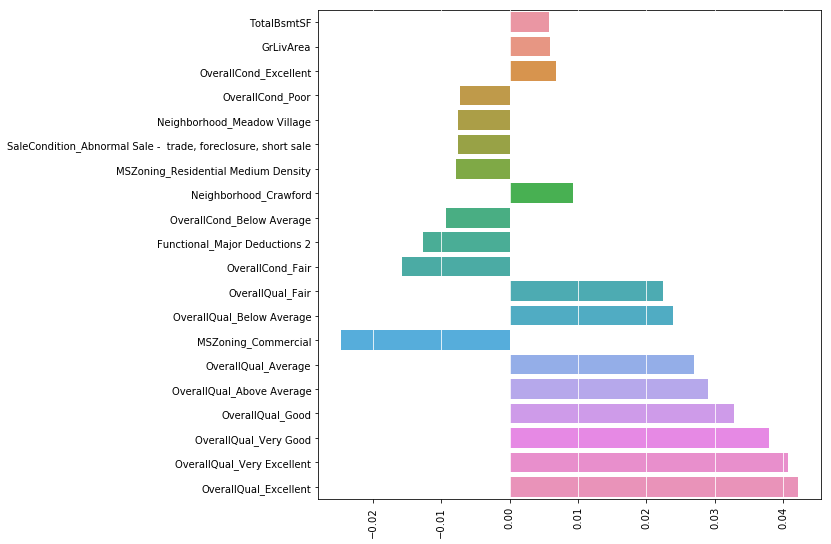

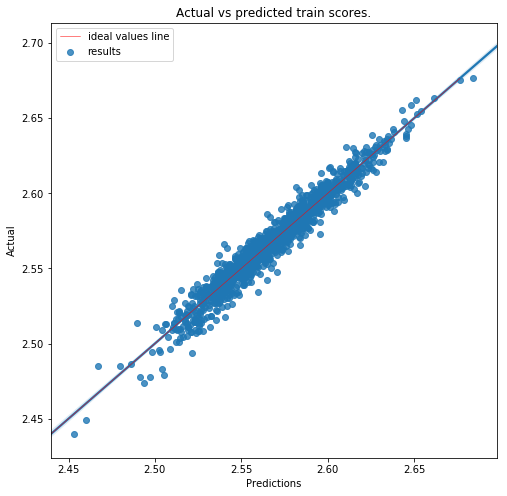

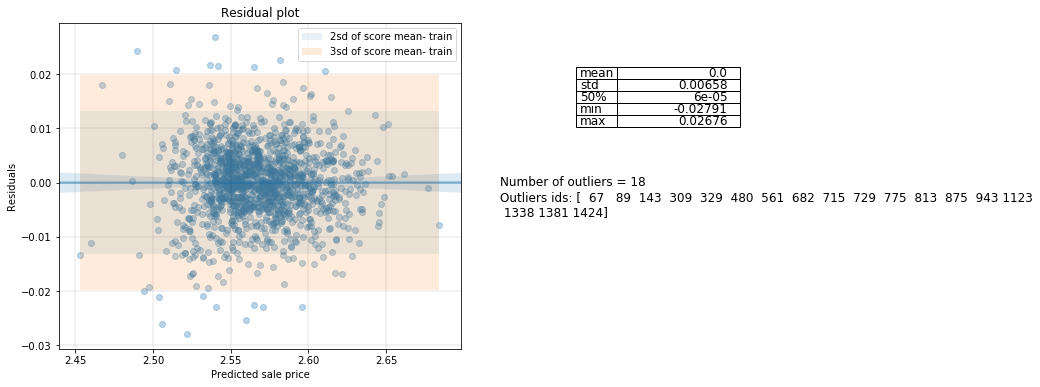

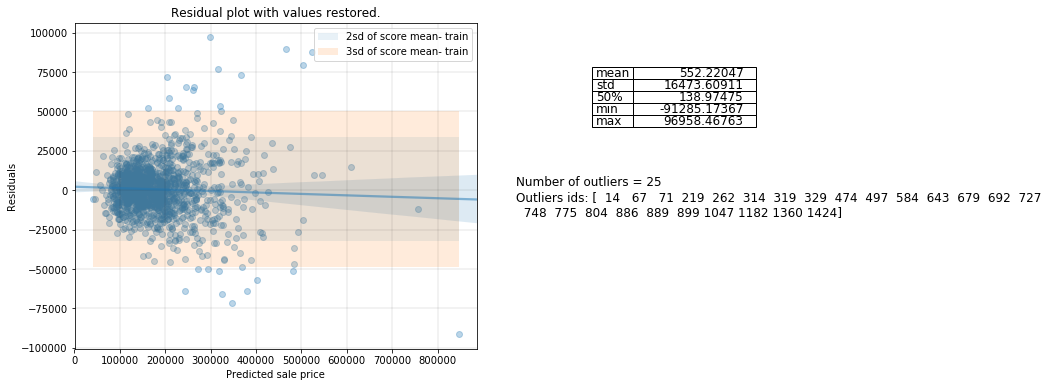

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


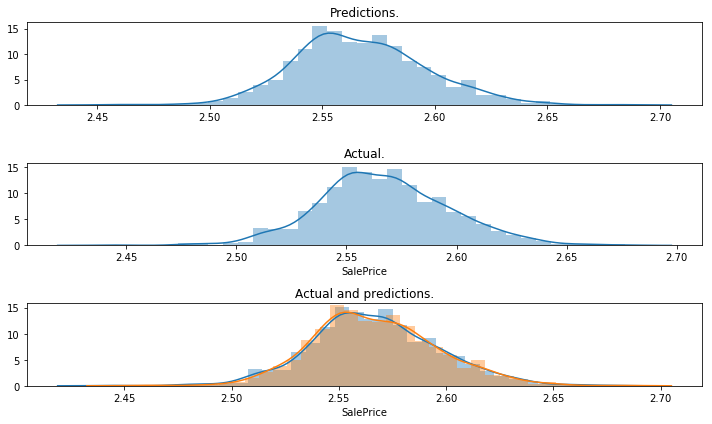

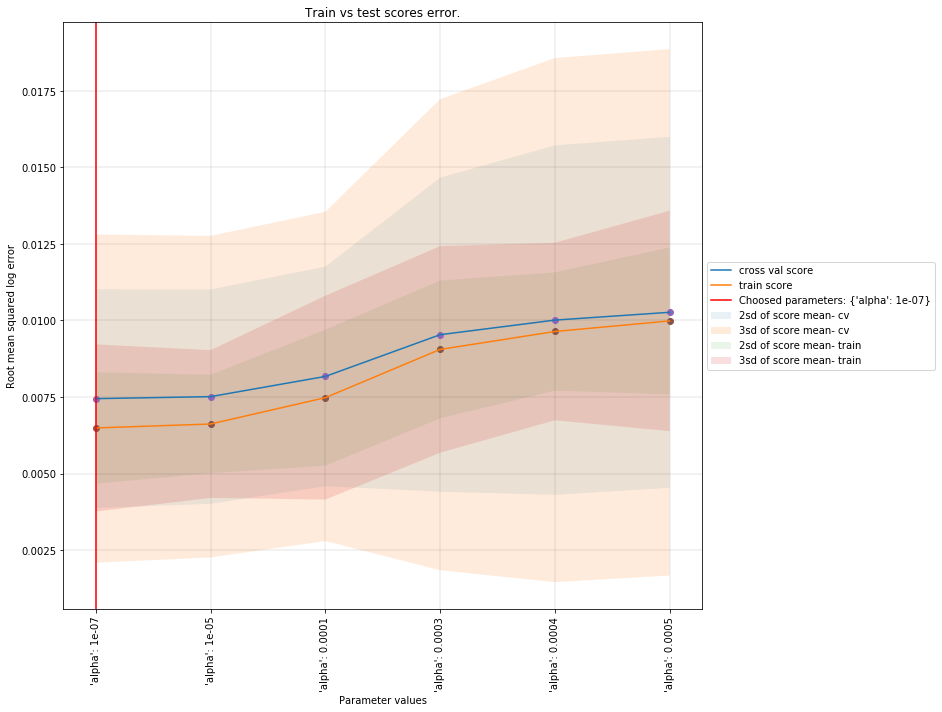

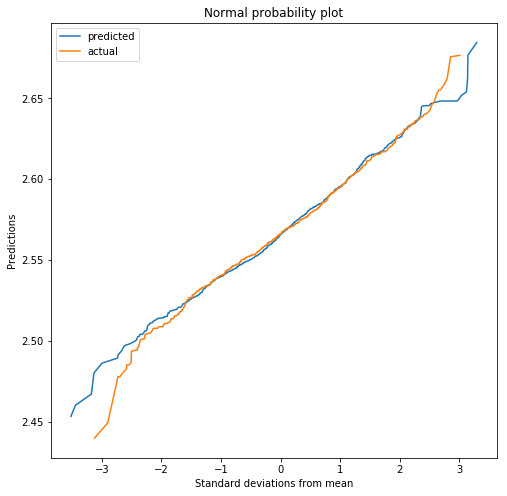

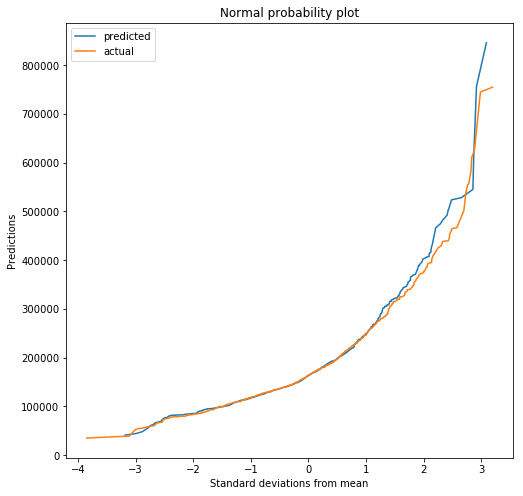

In [23]:
results[0].plot_results()

We can also plot only selected methods. I will show it on example of random forrest. 

There are 5 plots aviable:
* plot_actual_vs_predicted_train_scores,
* plot_best_predictors,
* plot_normal_probability,
* plot_residuals_for_train_data_set,
* plot_results_distplot

Initialization of results plotter:

In [8]:
from utils.plots.plotter import ResultsPlotter 
tree_results = results[3]
xgb_results = results[4]
tree_rp = ResultsPlotter(tree_results)
xgb_rp = ResultsPlotter(xgb_results)

Best predictors show us most important columns choosed by given algorithm. You can choose number of features to plot.

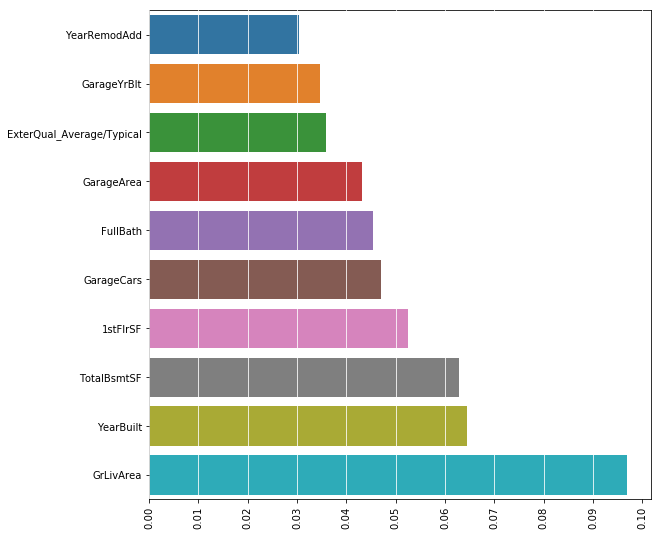

In [40]:
tree_rp.plot_best_predictors(10)

To get numerical values:

In [45]:
tree_results.coefficients.sort_values().tail(10)

YearRemodAdd                 0.030480
GarageYrBlt                  0.034583
ExterQual_Average/Typical    0.035890
GarageArea                   0.043097
FullBath                     0.045468
GarageCars                   0.046968
1stFlrSF                     0.052410
TotalBsmtSF                  0.062788
YearBuilt                    0.064491
GrLivArea                    0.096974
dtype: float64

You can gain insight on which algorithm chooses which features. It may be usefull in feature selection.

### Creating actual vs predicted train score plots

Actual vs predicted train score shows results of algorithm fit on training data.
When analyzing it search for outliers, variablity of predictions and difference between ideal values fit and predictions fit.

Bigger the variability of predictions- bigger the error. Normally You want to minimize the distance from the points to the diagonal (hence the error). However for some applications, overestimating can be way more problematic than underestimating.

Setting white grid style will help us to inspect graphs.

In case of random forest there is a visible difference in ideal values line and results.

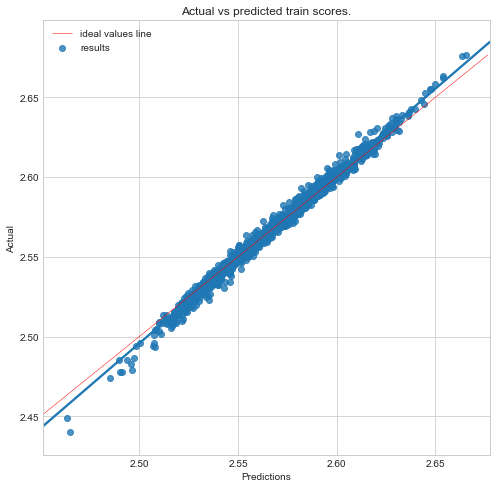

In [9]:
sns.set_style("whitegrid")
tree_rp.plot_actual_vs_predicted_train_scores()

Below we can see that xgb predictions are closer to ideal values, also regular fit is almost the same as ideal one.

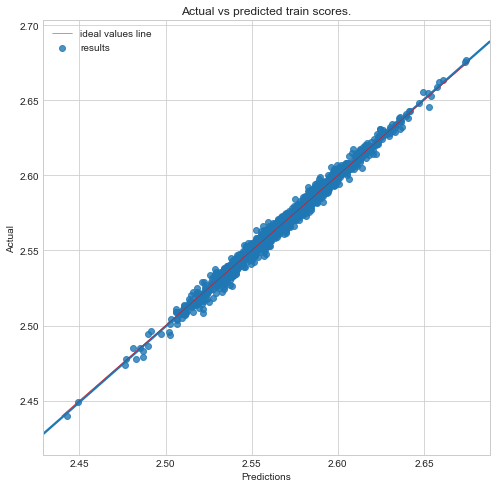

In [57]:
xgb_rp.plot_actual_vs_predicted_train_scores()

Lasso has higher variability on its predictions, but regular fit is almost the same as ideal one and there are more outliers visible.

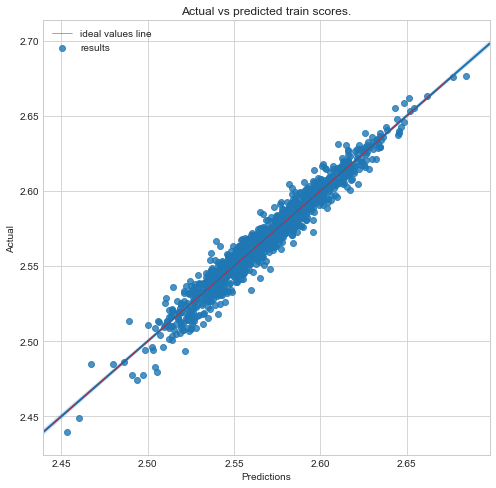

In [11]:
lasso_results = results[0]
lasso_rp = ResultsPlotter(lasso_results)
lasso_rp.plot_actual_vs_predicted_train_scores()

To gain more information about goodness of the fit we can examine r2 score, which tells us fraction of variance that is explained by the best-fit line. We can see that r2 score for tree results is higher than for lasso results, but lasso predicts better on test set (at least for now) so we can conclude that tree models are overfitting training data.

In [65]:
from sklearn.metrics import r2_score
r2_score(y_train, xgb_results.train_predictions)
r2_score(y_train, lasso_results.train_predictions)

0.98799853119761549

0.95122083317115824

Best score of r2 is 1, .988 means that 98.8 % of variance in data is explained by the line and .012% of the variance is due to unexplained effects. 

### Creating residual plots

When creating linear regression models we assume that output is in linear relation with features with epsilon (random error comonent) representing variability in y and is randomly distributed around line.
We have to make assumptions around epsilon too. Error terms are assumed to be:
* normally distributed,
* homoscedastic (at every X variance should be the same, image shows it's example),
* independent.

This assumptions may or may not be true, so this residual plot will help us make a decision.
If they are true- observed residuals should behave in similar fashion.
What we are hoping to see is a random scattering of points- nothing giving any indication that assumptions of a model are false.

Below I present problems that can be noticed by using residual plots.
<img src=https://i.stack.imgur.com/RU17l.png></img>

Sources:
* [image source](https://stats.stackexchange.com/questions/76226/interpreting-the-residuals-vs-fitted-values-plot-for-verifying-the-assumptions)
* [more interpretating informations](https://stats.stackexchange.com/questions/82682/how-do-i-interpret-this-fitted-vs-residuals-plot)
* **[very helpfull video](https://www.youtube.com/watch?v=iMdtTCX2Q70)**

When we plot lasso residuals everything seems to be resonable.

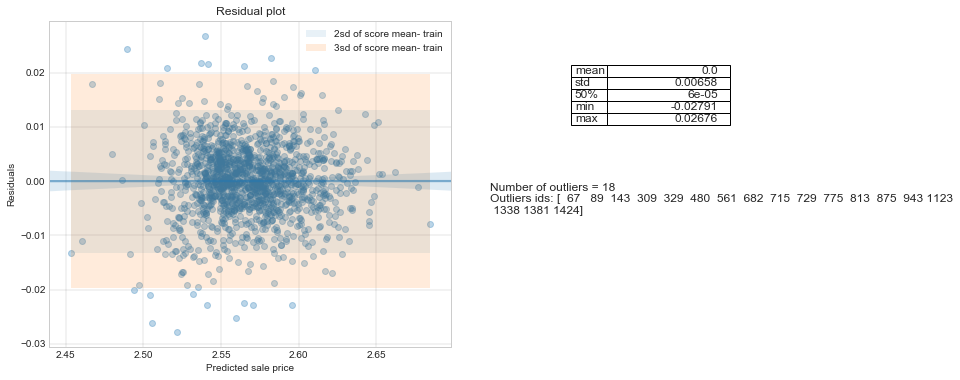

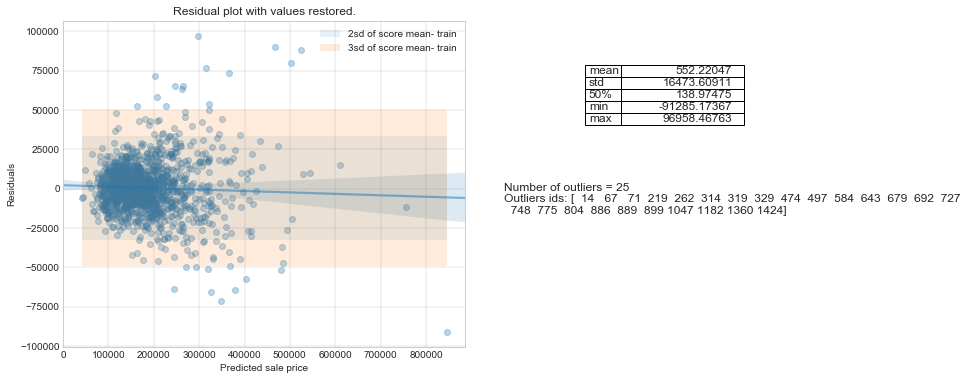

In [68]:
lasso_rp.plot_residuals_for_train_data_set()

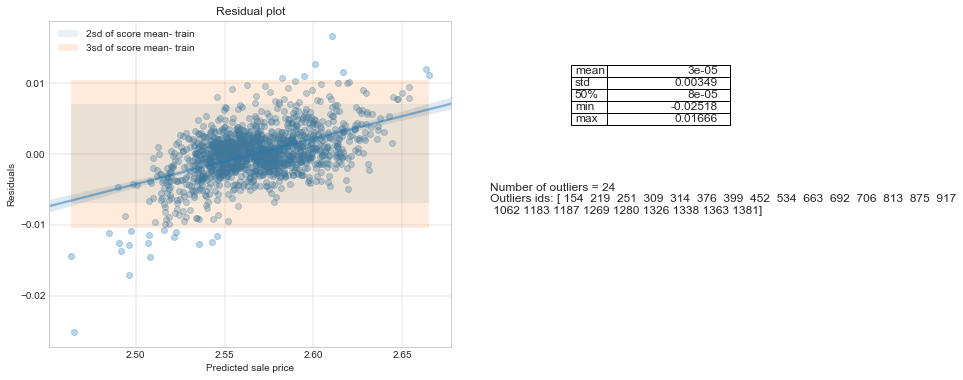

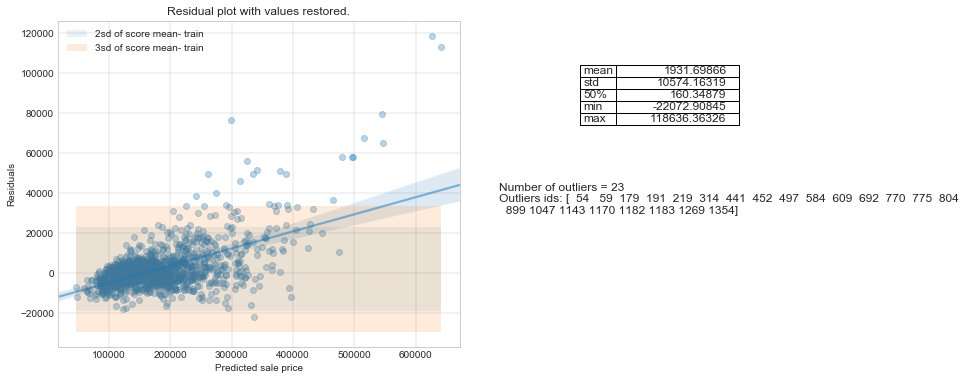

In [69]:
tree_rp.plot_residuals_for_train_data_set()

But the residual plot with restored values of random forest yields heteroscedasticity.
Our model have a problem, variance is increasing with saleprice.

There are few ways to deal with heteroscedasticity:
* use weighted regression to deal with changing variance,
* use box-cox transformation of variables,

Effect of heteroscedascity is described widely [here](https://arxiv.org/pdf/1606.05273.pdf).

### Normal probability plot

Normal probability plotting function comes from ThinkStats2 book. The normal probability plot is a special case of the Q–Q probability plot for a normal distribution. The way it is created is:
1. Sort the values in the sample.
2. From a standard normal distribution (µ = 0 and σ = 1), generate a random sample with the same size as the sample, and sort it.
3. Plot the sorted values from the sample versus the random values.

If the distribution of the sample is approximately normal, the result is a straight line with intercept mu and slope sigma. 
If there are a visible differences in predicted and actual plots we can se in whitch parts we have a problem.
We will obtain different results on every invocation, because of generation of random sample. Probably it would be better to perform multiple draws and take mean of results.

[Normal Probability plot](https://en.wikipedia.org/wiki/Normal_probability_plot)

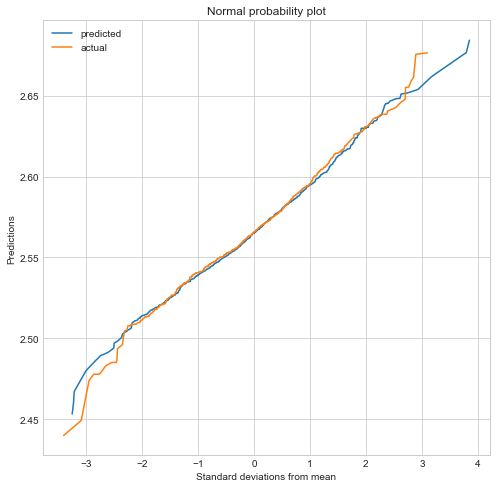

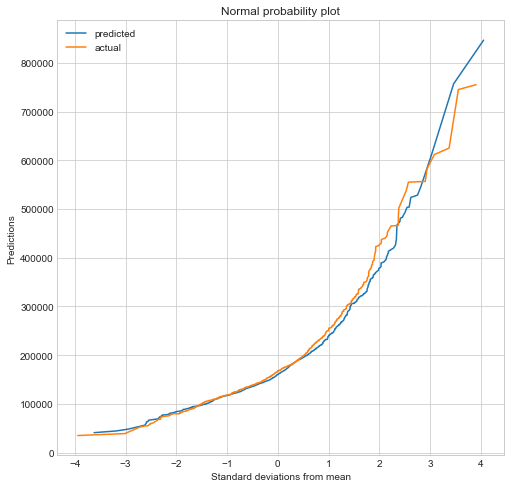

In [45]:
lasso_rp.plot_normal_probability()

And the last plot is results distribution plot, another way to determine how good are predictions and how they behave. Because of high dependency of bin size in histogram it may be wise to change default one to gain better understanding of results.

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


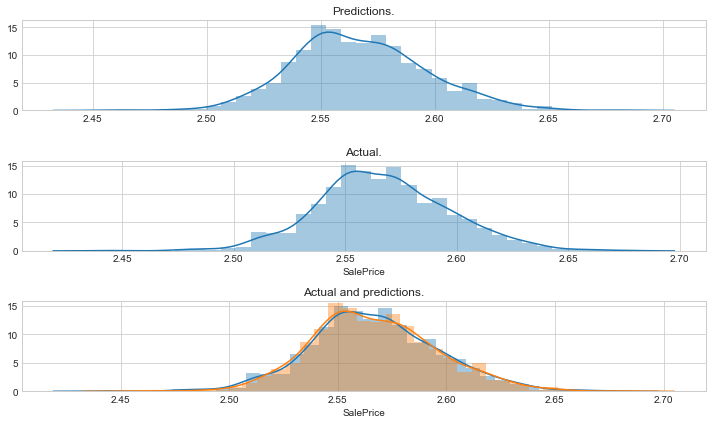

In [46]:
lasso_rp.plot_results_distplot()